**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [ ]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [ ]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [ ]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993825,  0.01941087,  0.03787041, ..., -0.03488846,
         0.06299512,  0.04635989],
       [ 0.00634238,  0.00814594,  0.03071934, ..., -0.01478722,
        -0.03080936, -0.03316408],
       [ 0.06336872, -0.02027135, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439984],
       ...,
       [ 0.08775924,  0.03609739,  0.01263063, ..., -0.03102781,
        -0.03361675,  0.01928869],
       [ 0.05691193,  0.0538169 , -0.03995752, ..., -0.06598806,
        -0.05390476, -0.01037723],
       [ 0.07770479,  0.0508063 ,  0.02680679, ..., -0.0061413 ,
        -0.01313565,  0.02236262]], dtype=float32)

In [ ]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

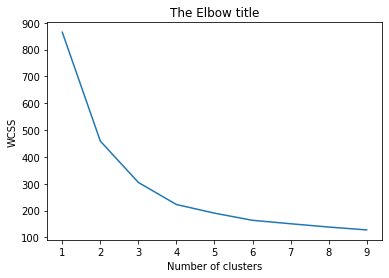

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans with no. of clusters you see fit the most

k = 3

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [ ]:
df_kmeans

,KMeans ID,texts
0,0,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...


In [ ]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [ ]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [ ]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [ ]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [ ]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','กิน','ทาน','ผม','กก','น','ร้า','ชา']
screening_words = stopwords + removed_words

new_words = {"สตารบัก","ชานมไข่มุก","อาหารอร่อย","ชานมไต้หวัน","อาหารทะเลอร่อย","สดมาก","คาเฟ่น่ารัก","บรรยากาศดี",
             "ร้านอาหารทะเล","ส้มตำปู","กาแฟอร่อย","ชานมอร่อย","ไข่มุกอร่อย","เบเกอรี่"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชานมไข่มุก, 9), (นม, 5), (เครื่องดื่ม, 4), (..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คว...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 14), (อร่อย, 10), (อาหาร, 9), (รี..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, นึง, เด, Artof...","[(ร้านกาแฟ, 25), (กาแฟ, 21), (ชอบ, 10), (คาเฟ่..."


In [ ]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ชานมไข่มุก', 9), ('นม', 5), ('เครื่องดื่ม', 4), ('ไข่มุก', 4), ('น้ำ', 3), ('ตั้งอยู่', 3), ('รีวิว', 3), ('ลอง', 3), ('เดิน', 3), ('ปั่น', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('แวะ', 2), ('เติม', 2), ('นขา', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('เจอ', 2), ('ขาย', 2)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 14), ('อร่อย', 10), ('อาหาร', 9), ('รีวิว', 7), ('บ้าน', 6), ('ส้มตำ', 6), ('ซอย', 6), ('สาขา', 6), ('กาแฟ', 6), ('เพื่อน', 5), ('ไทย', 5), ('เมนู', 5), ('สวัสดี', 4), ('ถนน', 4), ('ราคา', 4), ('แซ่บ', 4), ('คน', 4), ('รอบ', 4), ('บอ', 4), ('เวลา', 4)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 25), ('กาแฟ', 21), ('ชอบ', 10), ('คาเฟ่', 6), ('แวะ', 6), ('ดี', 6), ('รี่', 5), ('กา', 5), ('น่ารัก', 5), ('นั่ง', 5), ('สวัสดี', 5), ('เจอ', 5), ('รีวิว', 5), ('หา', 5), ('ชั้น', 5), ('คน', 4), ('นึง', 4), ('อ', 4), ('เบเกอรี่', 4), ('อร่อย', 4)]



**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [ ]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 491), ('รสชาติ', 407), ('ดี', 335), ('เมนู', 309), ('กาแฟ', 306), ('สั่ง', 301), ('อาหาร', 275), ('ราคา', 273), ('(', 270), (')', 250)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3)]

Cluster ID : 2

Most common words include : [('ดิชั้น', 4), ('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ("['", 1), ('ดิ', 1), ('ช้ัน', 1), ('ทบ', 1), ('อาหาร', 1)]



**Step 4 - result discussion**

#Kmean
Use k = 3

Top_N_words = 10

First group (Bubble tea lover)
Dealing with bubble tea lover
Review about bubble tea

Secound group ( Restaurant )
Dealing with Restaurant
Review about location , good taste and branch of restaurant

Last group (Coffee lover)
Dealing with coffee lover
Review about coffee

#agglomorative
First group (Coffee lover)
Dealing with Coffee lover
Review about coffee and taste

Second group (Smootie lover)
Dealing with Smootie
Review about Smootie

Last group ( Restaurant )
Dealing with Restaurant
Review about taste and satisfied